In [177]:

from PIL import Image, ImageOps
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.backends.cudnn as cudnn
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
import os
from typing import List, Tuple
import rasterio
import rasterio.plot
import math
import time
import gc
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

cudnn.benchmark = True

In [178]:
ml_weights_dir = os.path.join('ML', 'weights')

In [179]:
gc.collect()
torch.cuda.empty_cache()

In [180]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [181]:
class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

In [182]:
weights = EfficientNet_V2_S_Weights.DEFAULT

In [201]:
seq_model = efficientnet_v2_s(weights=weights)

freez_model_base = True
if freez_model_base:
    for param in seq_model.parameters(): #freeze model
        param.requires_grad = False

seq_model.classifier[1] = nn.Linear(1280, len(classes))
print(seq_model.classifier)
model = nn.DataParallel(seq_model)
model = model.to(device)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


In [186]:
batch_size = 64

In [187]:
show_summary = False

if show_summary:
    summary(
        model,
        input_size=(batch_size, 3, 300, 300),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
    )

In [188]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset')

In [189]:
training_weights = pd.read_csv(os.path.join(dataset_dir, 'training_weights.csv'), index_col='label')
training_weights

,weight
label,
CLR,0.372369
FEW,0.927661
SCT,0.943670
BKN,0.916098
OVC,0.840202


In [190]:
class DatasetType(str, Enum):
    TRAINING = 'training'
    VALIDATION = 'validation'
    TEST = 'test'

class AimlsseImageDataset(Dataset):
    def __init__(self, type:DatasetType, dataset_dir:str, bands:List[str], station_radius:float,
                 transfrom=None, target_transform=None) -> None:
        super().__init__()
        self.bands_metadata = pd.read_csv(os.path.join(dataset_dir, f'bands_metadata.csv'))
        self.bands_metadata.set_index('band', inplace=True)
        bands_series = pd.Series(bands)
        invalid_bands = bands_series[~bands_series.isin(self.bands_metadata.index)].to_list()
        if any(invalid_bands):
            raise ValueError(f'Bands {invalid_bands} are not valid')
        if len(self.bands_metadata.loc[bands]['resolution [M]'].unique()) != 1:
            raise ValueError(f'Bands {bands} do not have the same resolution')
        self.bands = bands
        self.station_radius = station_radius
        self.img_labels = pd.read_csv(os.path.join(dataset_dir, f'{type.value}_labels.csv'))
        self.img_dir = os.path.join(dataset_dir, type.value)
        self.transform = transfrom
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index) -> Tuple[np.ndarray, int]:
        image = self.get_image(index)
        label = self.get_label(index)
        return image, label
    
    def get_image(self, index) -> np.ndarray:
        img_paths = [os.path.join(self.img_dir, self.img_labels.iloc[index]['station'],
                                  self.img_labels.iloc[index]['product_id'], f'{band}.jp2') for band in self.bands]
        images = [rasterio.open(path) for path in img_paths]
        image_tensors: List[np.ndarray] = [img.read(1).astype(np.float32) / 10000 for img in images]
        [img.close() for img in images]
        # Resize images with small size-differences to make them stackable
        image_side_length = int(1 + math.floor(2.0 * self.station_radius / float(self.bands_metadata.loc[self.bands].iloc[0]['resolution [M]'])))
        new_shape = (image_side_length, image_side_length)
        [img.resize(new_shape, refcheck=False) for img in image_tensors]
        # Stack images into final image, select label and perform transformations
        image_tensors_stacked = np.stack(image_tensors, axis=2)
        if self.transform:
            image_tensors_stacked = self.transform(image_tensors_stacked)
        return image_tensors_stacked

    def get_label(self, index) -> int:
        label = class_dict[self.img_labels.iloc[index]['max cloud cover']]
        if self.target_transform:
            label = self.target_transform(label)
        return label


In [191]:
composed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), interpolation=transforms.InterpolationMode.BICUBIC)
])

In [192]:
bands = ['B4', 'B3', 'B2']
station_radius = 8000.0
train_dataset = AimlsseImageDataset(DatasetType.TRAINING,           dataset_dir, bands, station_radius, transfrom=composed_transforms)
validation_dataset = AimlsseImageDataset(DatasetType.VALIDATION,    dataset_dir, bands, station_radius, transfrom=composed_transforms)
test_dataset = AimlsseImageDataset(DatasetType.TEST,                dataset_dir, bands, station_radius, transfrom=composed_transforms)

In [193]:
use_weighted_sampler = False
if use_weighted_sampler:
    num_samples = len(train_dataset)
    weights = [0] * num_samples
    for i in range(num_samples):
        label = train_dataset.get_label(i)
        weights[i] = training_weights.loc[class_names]['weight'].iloc[label]
    training_sampler = WeightedRandomSampler(weights, num_samples)

In [194]:
if use_weighted_sampler:
    train_dataloader =  DataLoader(train_dataset,       batch_size=batch_size, sampler=training_sampler)
else:
    train_dataloader =  DataLoader(train_dataset,       batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader =       DataLoader(test_dataset,        batch_size=batch_size, shuffle=True)

In [195]:
show_samples = False

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def imshow(inp: torch.Tensor, title=None):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    ax.imshow(inp.permute(1, 2, 0))
    plt.pause(0.001)  # pause a bit so that plots are updated

if show_samples:
    # Get a batch of training data
    inputs, classes = next(iter(train_dataloader))
    print(inputs.shape, [class_names[c] for c in classes.unique().numpy()])

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    out.shape
    
    imshow(out)

    for row in list(chunks([class_names[c] for c in classes.numpy()], 8)):
        print(row)

In [196]:
import copy


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    y_true = []
    y_pred = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataset = train_dataset
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataset = validation_dataset
                dataloader = validation_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            start_time = time.perf_counter()
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
            if phase == 'train':
                scheduler.step()
            end_time = time.perf_counter()
            phase_name = None
            if phase == 'train':
                phase_name = 'Training'
            elif phase == 'val':
                phase_name = 'Validation'
            print(f'{phase_name} took {end_time - start_time:.1f} [s]')

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double() / len(dataset)
            print(f'\tLoss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            print(f'\tPrecision: {precision} Recall: {recall} F1-Score: {f1_score}')

            # deep copy the model
            if phase == 'val' and f1_score > best_f1:
                best_f1 = f1_score
                best_model_wts = copy.deepcopy(model.state_dict())
            
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation F1-Score: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [197]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # _, preds = torch.max(outputs, 1)
            preds = outputs.data.max(1, keepdim=True)[1]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [198]:
use_weighted_loss_function = True
if use_weighted_loss_function:
    loss_function_weights = torch.tensor(training_weights['weight'].to_list())
    loss_function_weights = loss_function_weights.to(device)
    print(loss_function_weights)

tensor([0.3724, 0.9277, 0.9437, 0.9161, 0.8402], device='cuda:0')


In [199]:
def display_confusion_matrix(model, dataloader, num_images=None):
    # set the model to evaluation mode
    model.eval()

    # initialize the true and predicted labels
    true_labels = []
    predicted_labels = []

    # get predictions for N images from the dataloader
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if (num_images is not None) and (i == num_images):
                break
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels += labels.cpu().numpy().tolist()
            predicted_labels += predicted.cpu().numpy().tolist()

    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(classes)))

    # display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.title('Confusion matrix')
    plt.show()

In [202]:
if use_weighted_loss_function:
    criterion = nn.CrossEntropyLoss(loss_function_weights)
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq_model.classifier.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [174]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------


100%|██████████| 211/211 [07:09<00:00,  2.04s/it]


Training took 429.9 [s]
	Loss: 1.2101 Acc: 0.6591
	Precision: 0.6828411111075531 Recall: 0.6590572190927957 F1-Score: 0.6687678266704262


100%|██████████| 27/27 [00:55<00:00,  2.06s/it]


Validation took 55.6 [s]
	Loss: 1.2115 Acc: 0.6792
	Precision: 0.6874930912907576 Recall: 0.6613115617592836 F1-Score: 0.6719497793670844
Epoch 1/24
----------


 19%|█▉        | 41/211 [01:15<05:11,  1.83s/it]


KeyboardInterrupt: 

In [142]:
os.makedirs(ml_weights_dir, exist_ok=True)
torch.save(model_trained.state_dict(), os.path.join(ml_weights_dir, 'efficientnet_v2_s_tmp.pth'))

In [38]:
model_trained = model
model_trained.load_state_dict(torch.load(os.path.join(ml_weights_dir, 'efficientnet_v2_s_300img_x64_weighted_loss.pth')))

<All keys matched successfully>

In [68]:
visualization_dataloader = DataLoader(validation_dataset,  batch_size=1, shuffle=True)

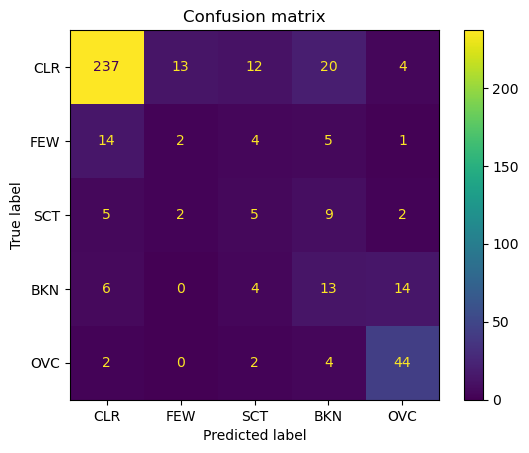

In [78]:
display_confusion_matrix(model_trained, validation_dataloader)